<a href="https://colab.research.google.com/github/Pedramghaderi/UHRED/blob/main/Training_SHRED_model_on_Hexadecane_and_water_sample_2021_02_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [ ]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

Dataset stored on google drive.
Mounting a virtual drive to getting access to the dataset.

In [ ]:
#Mounting a virtual drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read_tiff** is a function that imports the hyperspectral SRS images then converts them to a numpy array.

Function argument is path of the file follows by file name.


In [ ]:
#Reading tiff images and store them in to a numpy array
def read_tiff(path) :
    """
    path - Path of the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range (img.n_frames) : 
        img.seek(i)
        images.append(np.array(img))
        
    return np.array(images)  

Input data are called **"target_data"** and **"noisy_data"**.

target_data is considered as the ground-truth which is used for SHRED model and recorded at a high input laser power.


noisy_data is considered as the dataset that recorded while the input laser power kept low. Decreasing the input laser power added some noise to the data.

In [ ]:
#Importing data, store it in to a numpy array (target_data) and then print the shape of it. 
target_data = read_tiff("/content/drive/My Drive/Data/2020-03-05 oil and water /Scan 2/60 mw/60 mW.tif") 
#printing size of the data file
print(target_data.shape)

(92, 256, 256)


In [ ]:
#Importing data, store it in to a numpy array (noisy_data) and then print the shape of it.
noisy_data = read_tiff("/content/drive/My Drive/Data/2020-03-05 oil and water /Scan 2/20 mW/20 mW.tif") 
#printing size of the data file
print(noisy_data.shape)

(92, 256, 256)


**Comparison between the ground truth and the noisy dataset.**

Ploting a frame of hyperspectral SRS image dataset.

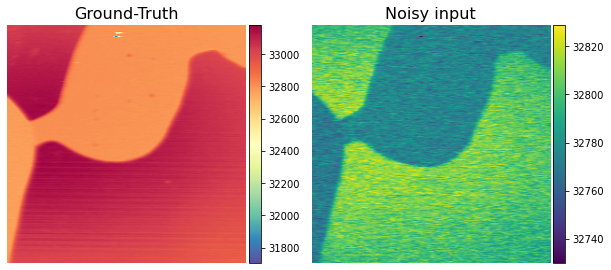

In [ ]:
#ploting a sample frame from input data. 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 10))

im1 = ax1.imshow(target_data[47,:,:],cmap = 'Spectral_r')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(noisy_data[47,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax1.set_title('Ground-Truth', fontsize = 16)
ax2.set_title('Noisy input', fontsize = 16)
ax2.set_axis_off()
ax1.set_axis_off()

plt.show()


Finding min, max and mean value of the input data.

In [ ]:
#Reading min, max and mean value of the imported data (GROUND-TRUTH).
mean_input_G = np.mean(target_data)
max_input_G = np.max(target_data)
min_input_G = np.min(target_data)
differenc_G = max_input_G-min_input_G
print("\t GROUND-TRUTH INFO \n")
print("\t\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
print (' Mean value is = %f \n Max value is = %f \n Min value is = %f \n Difference of max and min value is = %f ' % (mean_input_G,max_input_G,min_input_G, differenc_G))

	 GROUND-TRUTH INFO 

	\\\\\\\\\\\\\\\
 Mean value is = 32811.622950 
 Max value is = 34815.000000 
 Min value is = 30720.000000 
 Difference of max and min value is = 4095.000000 


In [ ]:
#Reading min, max and mean value of the imported data (GROUND-TRUTH).
mean_input_N = np.mean(noisy_data)
max_input_N = np.max(noisy_data)
min_input_N = np.min(noisy_data)
differenc_N = max_input_N-min_input_N
print("\t NOISY INPUT INFO \n")
print("\t\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
print (' Mean value is = %f \n Max value is = %f \n Min value is = %f \n Difference of max and min value is = %f ' % (mean_input_N,max_input_N,min_input_N, differenc_N))

	 NOISY INPUT INFO 

	\\\\\\\\\\\\\\\
 Mean value is = 32776.046715 
 Max value is = 32837.000000 
 Min value is = 32718.000000 
 Difference of max and min value is = 119.000000 


Normalizing & reshaping the dataset (both ground-truth and noiy input)

In [ ]:
#Data Normalization [0-1]
N_GT = np.zeros ((256,256,92))
for i in range (256):
  for j in range (256):
    for k in range (92):

      N_GT[i,j,k] = ((target_data[k,i,j]-mean_input_G))/(max_input_G-min_input_G)

In [ ]:
#Check the normalization for GT
print(np.max(N_GT)-np.min(N_GT))

1.0


In [ ]:
#Data Normalization [0-1]
N_noisy = np.zeros ((256,256,92))
for i in range (256):
  for j in range (256):
    for k in range (92):

      N_noisy[i,j,k] = ((noisy_data[k,i,j]-mean_input_N))/(max_input_N-min_input_N)

In [ ]:
#Check the normalization for noisy input
print(np.max(N_noisy)-np.min(N_noisy))

1.0


Removing hot pixels in the noisy dataset by averaging over neighbourhood pixels around the saturated pixel (hot pixel). 

In [ ]:
#Averagin hot pixel neighbourhood
# for k in range(92):
P_N_Noisy = np.empty((256,256,92))
P_N_Noisy = N_noisy
avg_value_1 = np.empty((92))

for k in range (92):
  avg_value_1[k] = (1/3)*(np.mean(N_noisy[2:6,110:125,k])+np.mean(N_noisy[11:12,110:125])+np.mean(N_noisy[14:16,110:125,k]))

for i in range(13):
    for k in range(92):
      P_N_Noisy[7:11,118+i,k] = avg_value_1[k]+0.00005*np.random.uniform(0.8*avg_value_1[k],1.2*avg_value_1[k])
      P_N_Noisy[13,113+i,k] = avg_value_1[k]+0.00005*np.random.uniform(0.8*avg_value_1[k],1.2*avg_value_1[k])

Removing hot pixels in the noisy dataset by averaging over neighbourhood pixels around the saturated pixel (hot pixel). 

In [ ]:
#Averagin hot pixel neighbourhood
# for k in range(92):
P_N_GT = np.empty((256,256,92))
P_N_GT = N_GT
avg_value_1 = np.empty((92))
avg_value_2 = np.empty((92))
avg_value_3 = np.empty((92))
avg_value_4 = np.empty((92))

for k in range (92):
  avg_value_1[k] = (1/3)*(np.mean(N_GT[0:6,111:126,k])+np.mean(N_GT[11:12,112:126,k])+np.mean(N_GT[14,112:126]))
  avg_value_3[k] = np.mean(N_GT[40,70:80,k])
  avg_value_4[k] = np.mean(N_GT[144,113:126,k])

for i in range(15):
    for k in range(92):
      P_N_GT[7:11,114+i,k] = avg_value_1[k]+0.00005*np.random.uniform(0.8*avg_value_1[k],1.2*avg_value_1[k])
      P_N_GT[12:14,113+i,k] = avg_value_1[k]+0.00005*np.random.uniform(0.8*avg_value_1[k],1.2*avg_value_1[k])
      P_N_GT[61,56+i,k] = P_N_GT[59,56+i,k]
      P_N_GT[41,70+i,k] = avg_value_3[k]+0.00005*np.random.uniform(0.8*avg_value_3[k],1.2*avg_value_3[k])
      P_N_GT[146,113+i,k] = avg_value_4[k]+0.00005*np.random.uniform(0.8*avg_value_4[k],1.2*avg_value_4[k])

Normalization of both ground-truth and noisy input.

Mena value = 0

STD = 1

In [ ]:
P_N_GT = (P_N_GT-np.mean(P_N_GT))/(np.max(P_N_GT)-np.min(P_N_GT))
P_N_Noisy = (P_N_Noisy-np.mean(P_N_Noisy))/(np.max(P_N_Noisy)-np.min(P_N_Noisy))

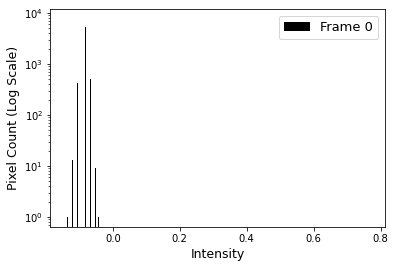

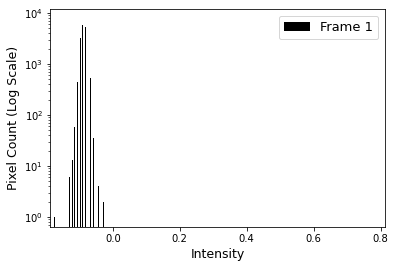

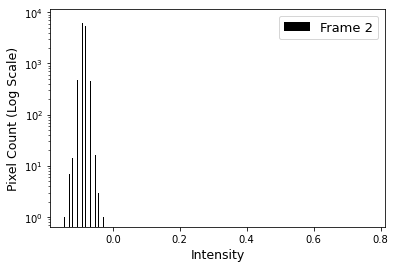

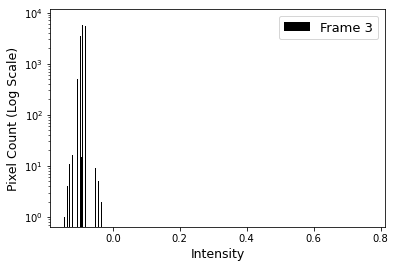

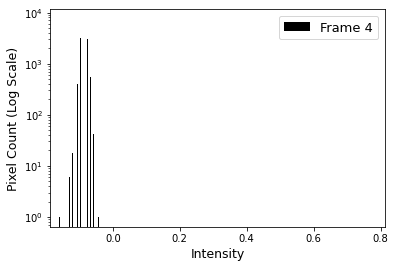

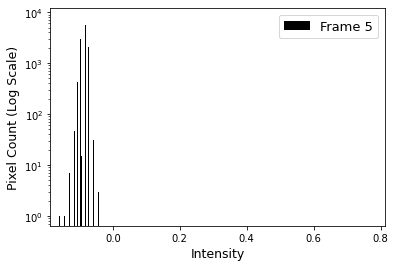

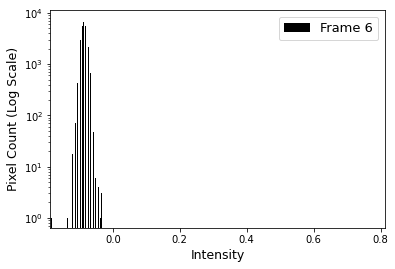

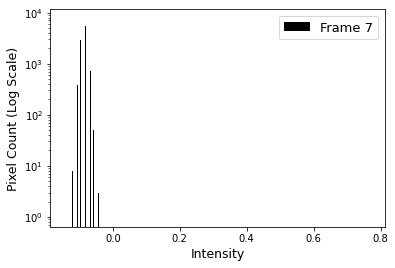

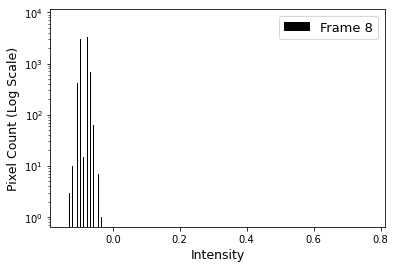

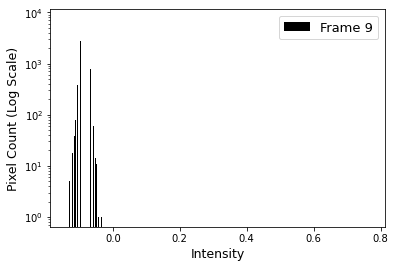

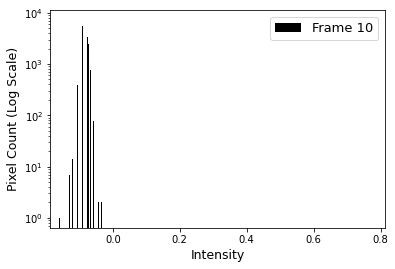

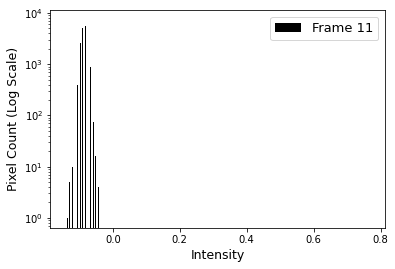

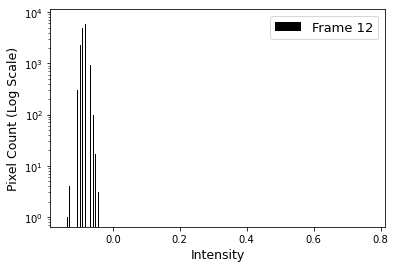

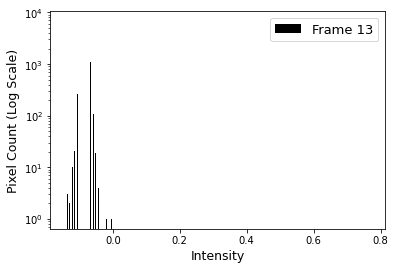

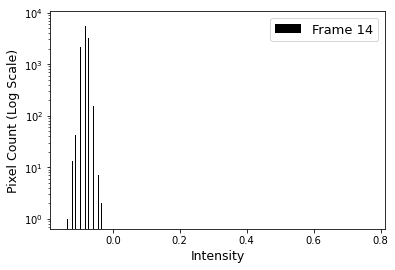

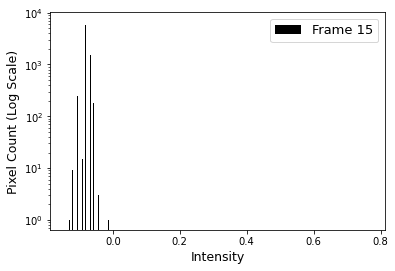

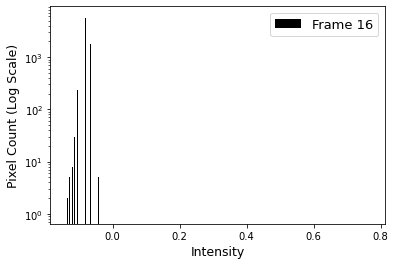

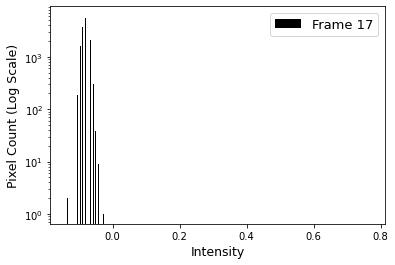

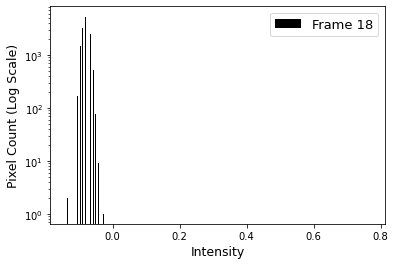

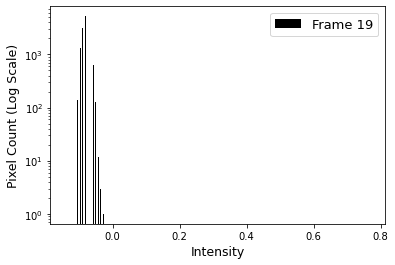

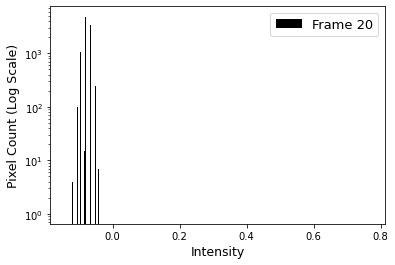

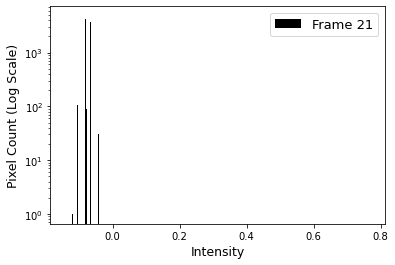

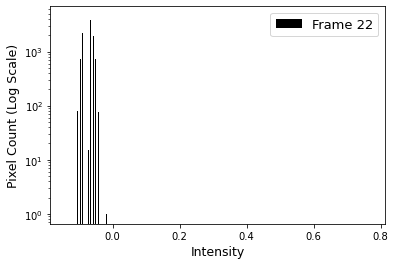

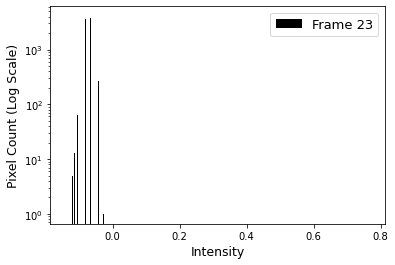

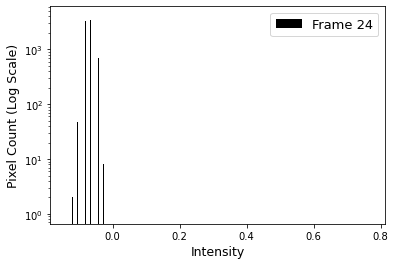

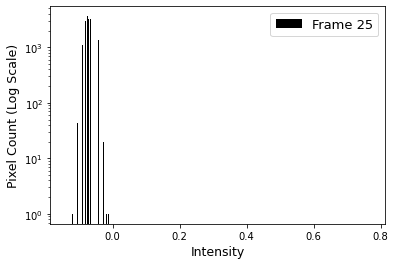

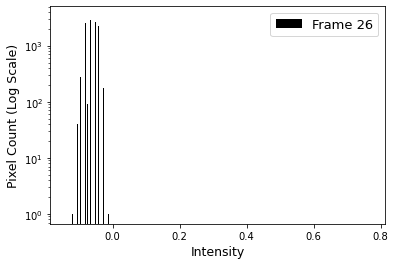

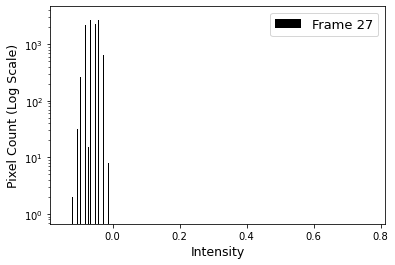

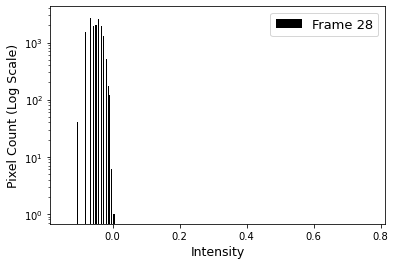

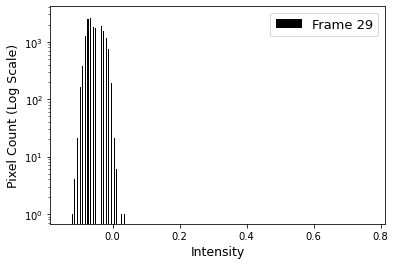

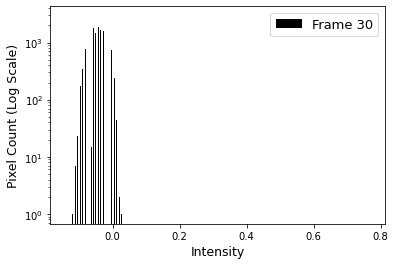

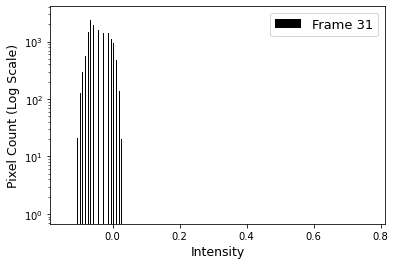

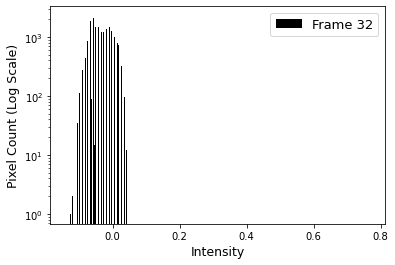

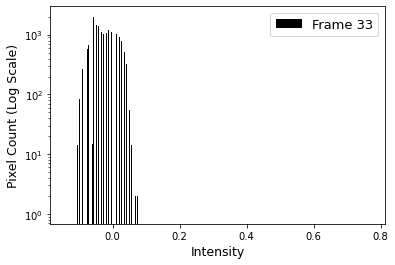

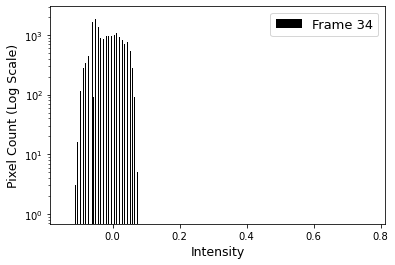

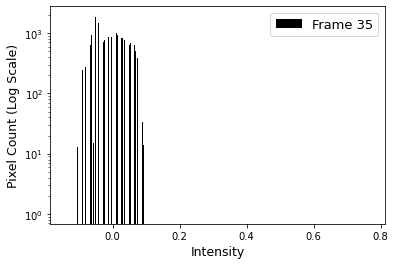

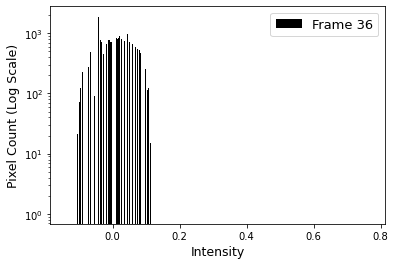

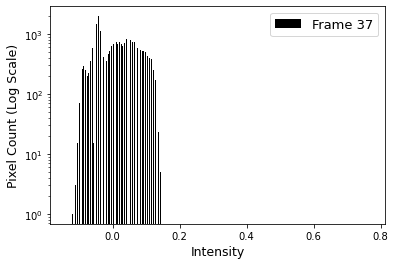

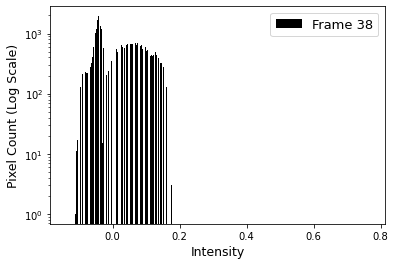

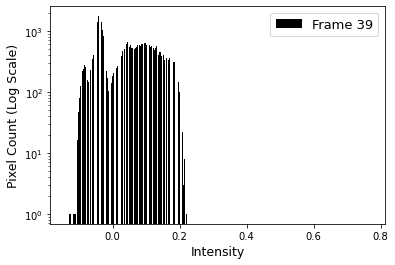

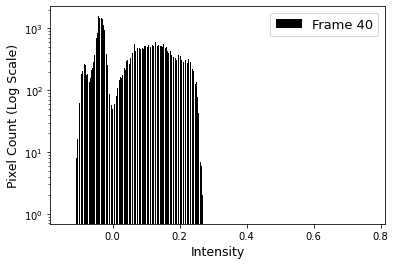

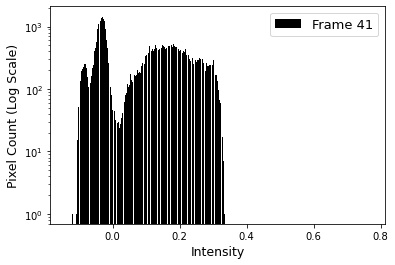

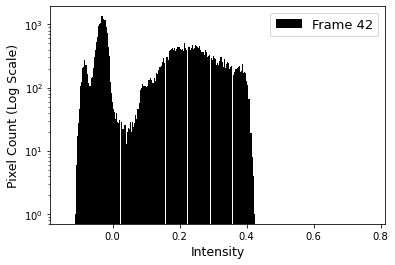

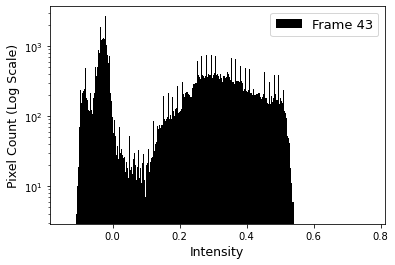

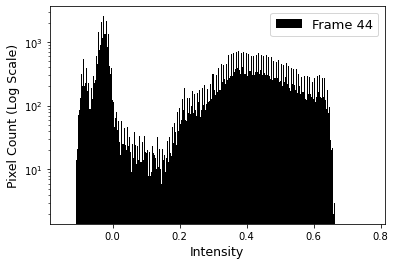

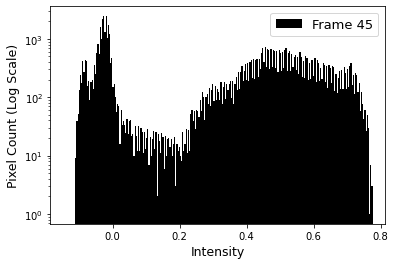

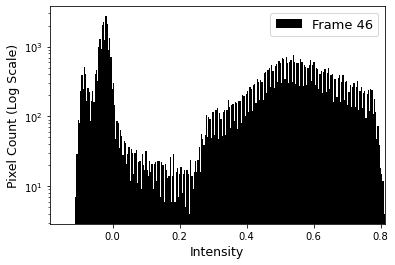

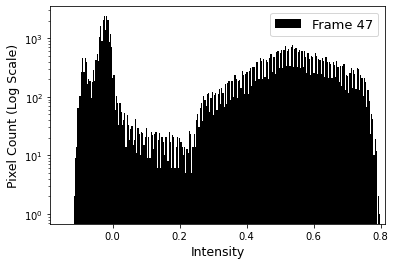

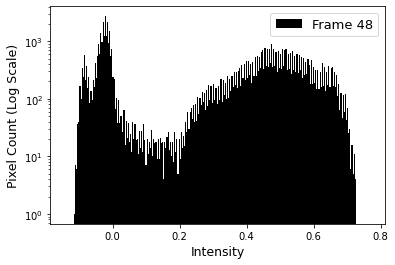

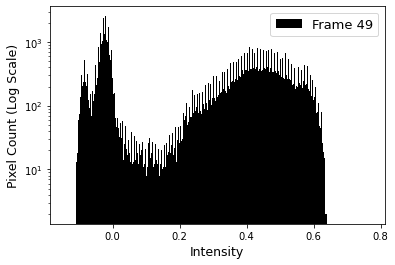

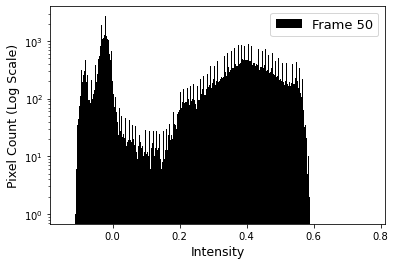

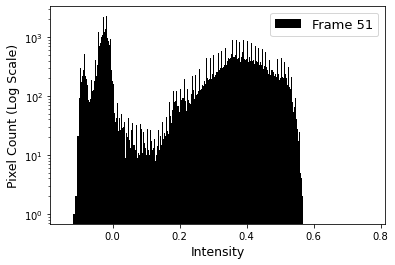

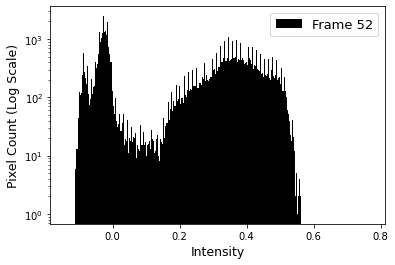

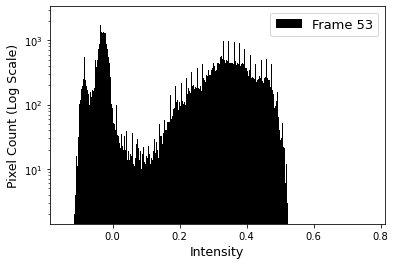

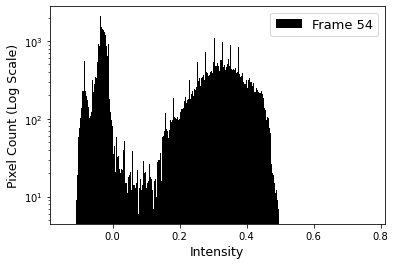

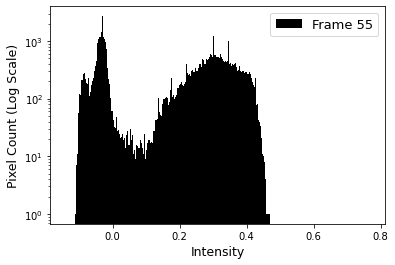

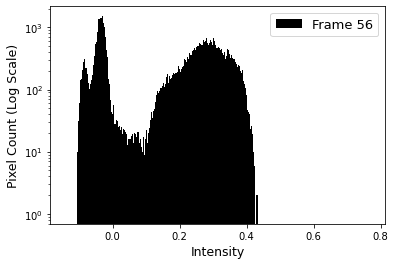

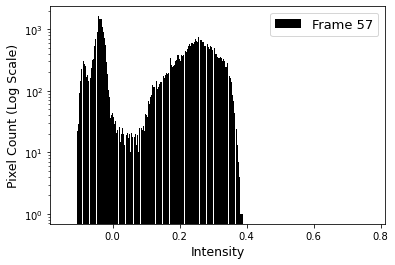

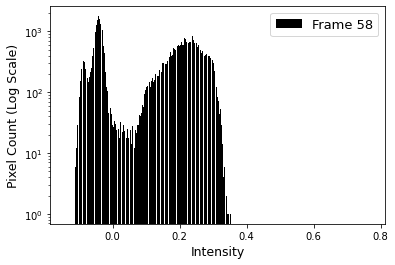

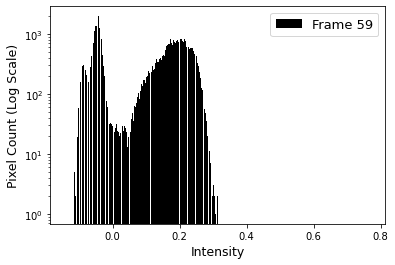

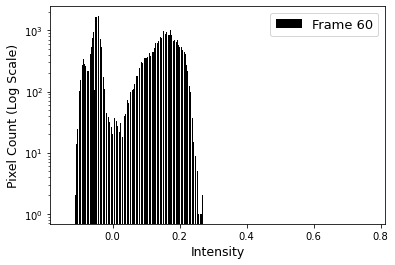

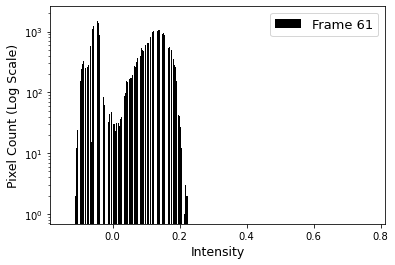

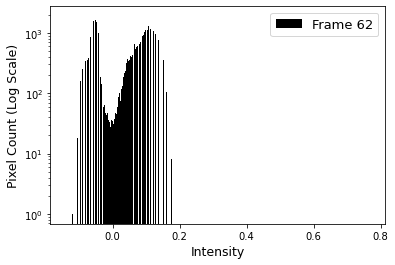

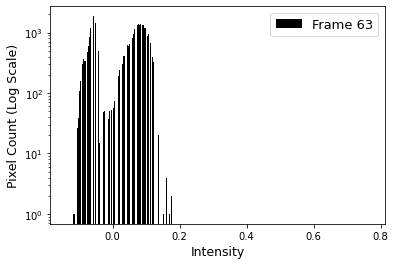

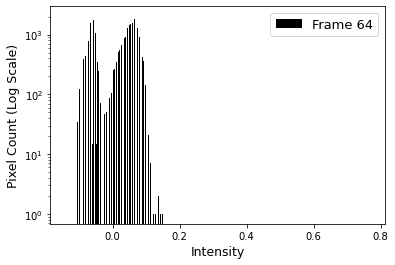

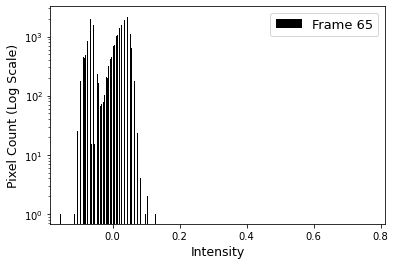

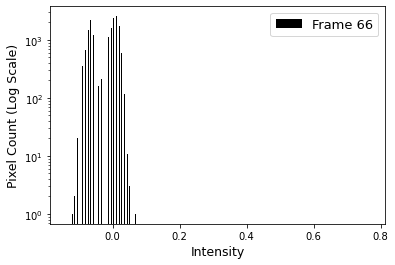

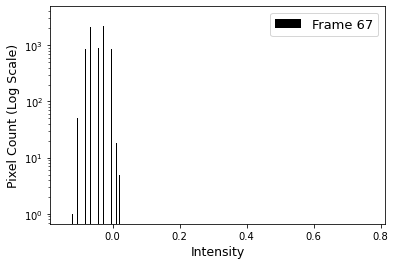

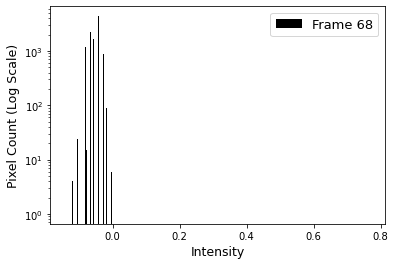

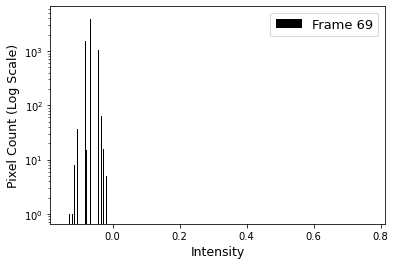

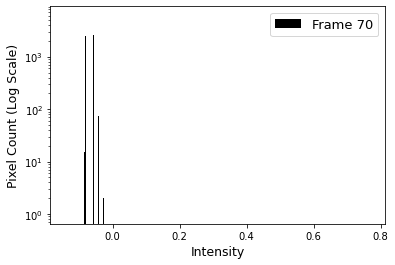

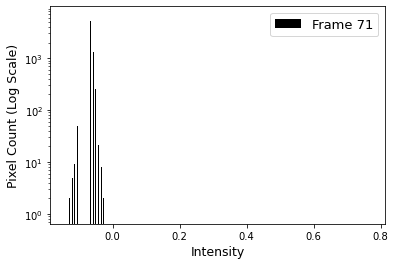

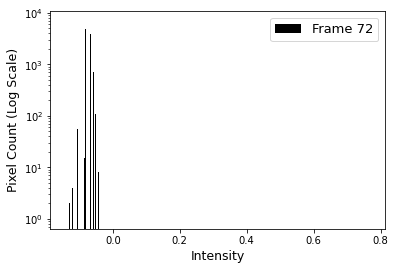

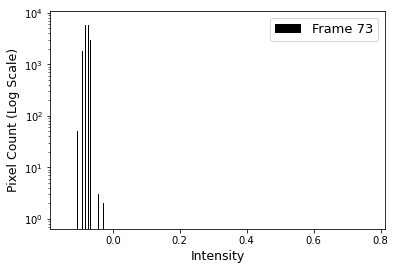

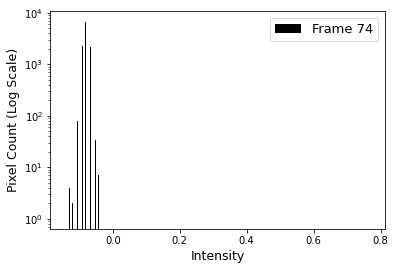

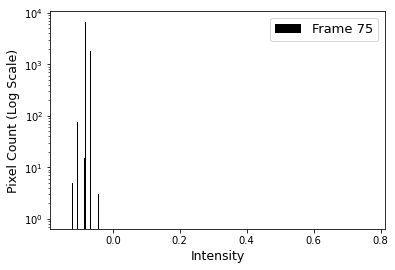

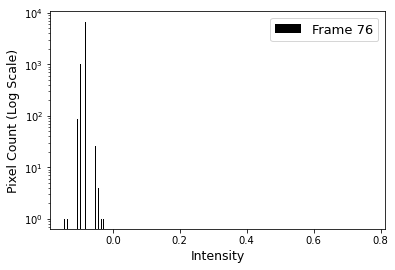

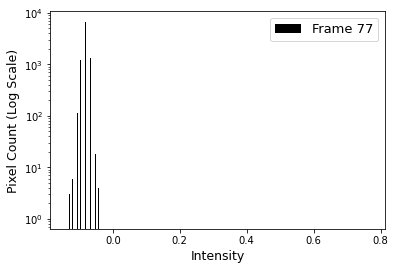

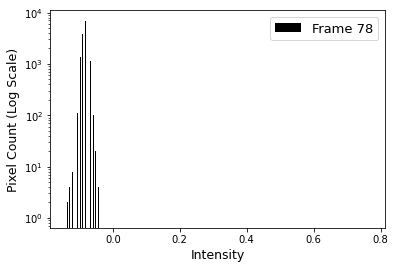

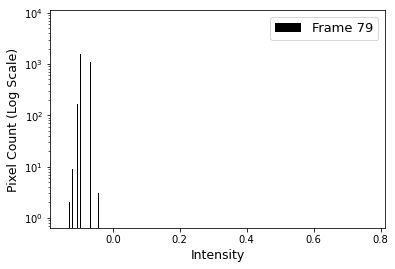

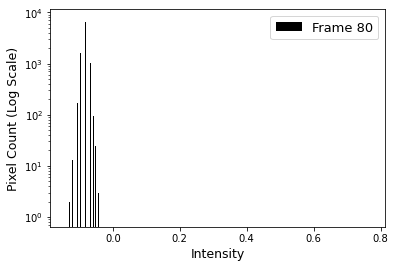

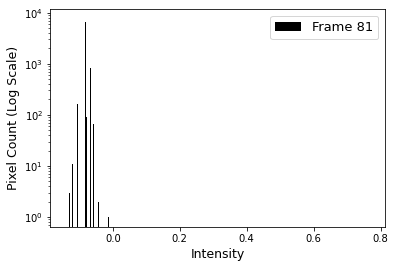

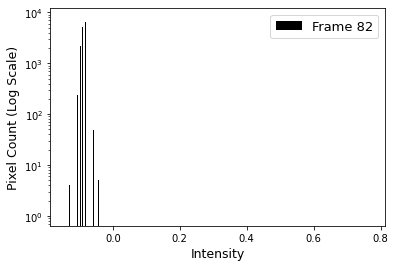

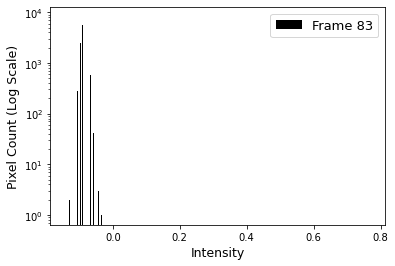

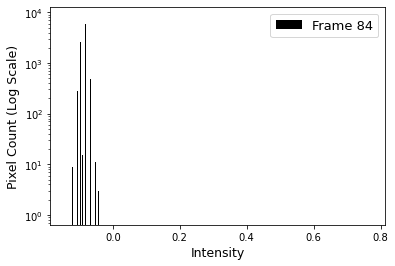

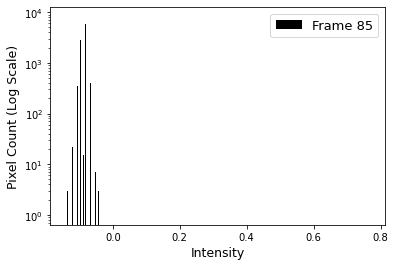

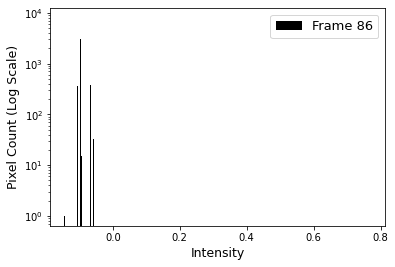

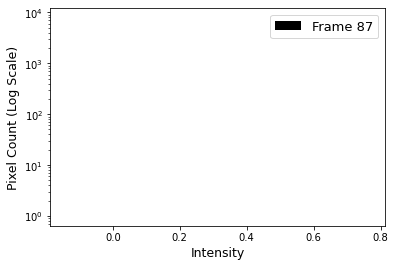

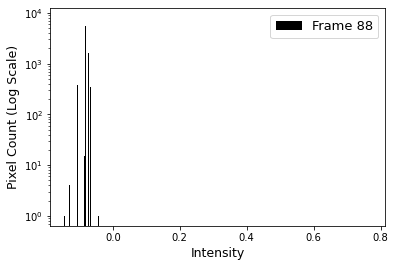

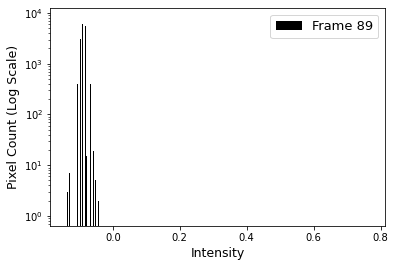

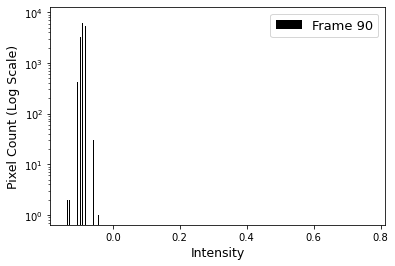

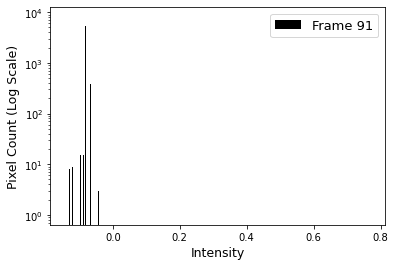

In [ ]:
#Ploting a all 92 images and save it in a file as img. "Processe ground truth"
A = P_N_GT.reshape(-1,92)
outpath = "/content/drive/My Drive/Data/2020-04-23/FOV1/Ground Truth/Processed ground truth/Histogram"
for i in range (92):
  
  plt.hist(A[:,i], bins = 256, color ="black")
  plt.xlabel("Intensity", fontsize = "12.5")
  plt.ylabel("Pixel Count (Log Scale)", fontsize = "12.5")
  plt.yscale("Log")
  plt.xlim(np.min(A),np.max(A))
  plt.legend(['Frame %d' %i], fontsize = "13")
 
 # plt.savefig(os.path.join(outpath,"frame_{0}.png".format(i)))
  plt.show()

Coverting the **numpy array** to the **pytorch tensor**

Reshape it. 

Copy them on google **GPU**




In [ ]:
#Converting numpy array to pyorch tensor and copy it on GPU (CUDA).
target_input_t = P_N_GT.reshape((65536,-1))
target_input_t = torch.from_numpy(target_input_t).float()
target_input_t = target_input_t.view(-1,1,92)
target_input_t = target_input_t.cuda()

In [ ]:
#Converting numpy array to pyorch tensor and copy it on GPU (CUDA).
noisy_input_t = P_N_Noisy.reshape((65536,-1))
noisy_input_t = torch.from_numpy(noisy_input_t).float()
noisy_input_t = noisy_input_t.view(-1,1,92)
noisy_input_t = noisy_input_t.cuda()

In [ ]:
#printing the shape of input pytorch tensors
print(target_input_t.shape)
print(noisy_input_t.shape)

torch.Size([65536, 1, 92])
torch.Size([65536, 1, 92])


Denoising convolutional autoencoder model.

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self,zdims):
    super().__init__()
    self.zdims = zdims
    #Encoder layer
    self.encoder = nn.Sequential(nn.Conv1d(1,4,kernel_size = 4, stride = 2),
            nn.MaxPool1d(kernel_size = 4, stride = 2),
            nn.Tanh(),
                    
            
            nn.Conv1d(4,8,kernel_size=4, stride = 2),
            nn.MaxPool1d(kernel_size = 3,stride = 1),
            nn.Tanh(),
                     
            
            nn.Conv1d(8,12,kernel_size = 3, stride = 1),
            nn.MaxPool1d(kernel_size = 2,stride = 1),
            nn.Tanh(),

            nn.Conv1d(12,16,kernel_size = 2, stride = 1),
            nn.MaxPool1d(kernel_size = 2, stride = 1),
            nn.Tanh()
            
            )

    
    #Decoder layer
    self.decoder = nn.Sequential(nn.ConvTranspose1d(16,12,kernel_size = 2, stride = 2),
            nn.Tanh(),
            

            nn.ConvTranspose1d(12,8,kernel_size = 4,stride = 1),
            nn.Tanh(),
                        

            nn.ConvTranspose1d(8,4,kernel_size= 3,stride = 3),
            nn.Tanh(),

            nn.ConvTranspose1d(4,1,kernel_size = 12, stride = 4),
            nn.Tanh())
    

    #Deconv FC LAYER
    self.fc_e = nn.Linear(32,self.zdims)

    self.fc_d = nn.Linear(self.zdims,32)
        

  def encode(self,imgs):

      output = self.encoder(imgs)
      output = output.view(-1,32)
      output = self.fc_e(output)
      return output

  def decode(self,z):

      
      deconv_input = self.fc_d(z)
      deconv_input = deconv_input.view(-1,16,2)
      reconstructed_img = self.decoder(deconv_input)
      return reconstructed_img

  def forward(self,x):
    
      x = self.encode(x)
      reconstructed_img = self.decode(x)
      return reconstructed_img

In [ ]:
#Autoencoder 
print(Autoencoder(zdims = 20))

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 4, kernel_size=(4,), stride=(2,))
    (1): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Tanh()
    (3): Conv1d(4, 8, kernel_size=(4,), stride=(2,))
    (4): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Tanh()
    (6): Conv1d(8, 12, kernel_size=(3,), stride=(1,))
    (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Tanh()
    (9): Conv1d(12, 16, kernel_size=(2,), stride=(1,))
    (10): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (11): Tanh()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(16, 12, kernel_size=(2,), stride=(2,))
    (1): Tanh()
    (2): ConvTranspose1d(12, 8, kernel_size=(4,), stride=(1,))
    (3): Tanh()
    (4): ConvTranspose1d(8, 4, kernel_size=(3,), stride=(3,))
    (5): Tanh()
    (6): ConvTranspose1d(4, 1, kernel_size=(12,), stride=(4,))
    (7): Tanh()


Using pytorch dataloader module to make minibatch dataset for training.

70% of data used for training and 30% for validation.

In [ ]:
#Using dataloader module to split dataset between training and validation dataset. 
#concrete target and noisy dataset 
data_set = torch.utils.data.TensorDataset(target_input_t,noisy_input_t)
n_train = int(len(data_set)*0.7)
n_test = int(len(data_set)) - n_train
train_data_set, test_data_set = torch.utils.data.random_split(data_set, [n_train, n_test])

train_loader  = torch.utils.data.DataLoader(train_data_set, batch_size = 512, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(test_data_set, batch_size = 512, shuffle=True, drop_last=True)
for batch_idx, sample in enumerate(train_loader):
  inp, tar = sample
  print(inp.size())
  print(tar.size())
print ("//////////////////////////Test dataset//////////////////////////")
for batch_idx, sample in enumerate(test_loader):
  inp, tar = sample
  print(inp.size())
  print(tar.size())

torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])
torch.Size([512, 1, 92])


Defining model parameters and optimization method.

Learning rate = 0.001, scheduler "StepLR" used. 

Optimizer = Adam

Criterion = MSE


In [ ]:
#Defining hyper parameters of the model
### num of epochs and also learning rate was determind experimentally () 
learning_rate = 1e-3
num_epochs = 300
model = Autoencoder(zdims = 20).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
weight_decay=1e-5)

Training step.

[0.001]
Best loss at epoch 0
[0.001]
Best loss at epoch 1
[0.001]
Best loss at epoch 2
[0.001]
Best loss at epoch 3
[0.001]
Best loss at epoch 4
[0.001]
Best loss at epoch 5
[0.001]
Best loss at epoch 6
[0.001]
Best loss at epoch 7
[0.001]
Best loss at epoch 8
[0.001]
 Train Epoch : 10/300 	Loss : 0.0011
 Test Epoch : 10/300 	Loss : 0.0011
[0.001]
Best loss at epoch 10
[0.001]
Best loss at epoch 11
[0.001]
[0.001]
Best loss at epoch 13
[0.001]
Best loss at epoch 14
[0.001]
[0.001]
Best loss at epoch 16
[0.001]
Best loss at epoch 17
[0.001]
Best loss at epoch 18
[0.001]
 Train Epoch : 20/300 	Loss : 0.0010
 Test Epoch : 20/300 	Loss : 0.0010
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
Best loss at epoch 27
[0.001]
[0.001]
 Train Epoch : 30/300 	Loss : 0.0010
 Test Epoch : 30/300 	Loss : 0.0010
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
[0.001]
 Train Epoch : 40/300 	Loss : 0.0010
 Test Epoch : 40/300 	Loss : 0.0009
[0.001]
[0.001]
[0.001]

Text(0.5, 1.0, 'Loss vs # of iterations')

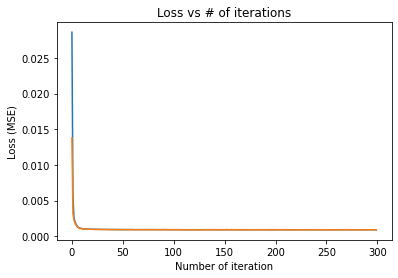

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=270, gamma=0.6, last_epoch=-1)
epoch_num = 0
train_error = []
test_error = []
best_error = 100
for epoch in range(num_epochs):
  print(scheduler.get_last_lr())
  loss_total = 0
  test_loss_total = 0
  model.train()
  for batch_idx, sample in enumerate(train_loader):
    tar, inp = sample
    tar, inp = tar.cuda(), inp.cuda()
    output = model(inp) 
    loss = criterion(output, tar)
    loss_total += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()
  loss_total = loss_total / (batch_idx+1)
  train_error.append(loss_total.item())

  model.eval()
  with torch.no_grad():
    for batch_idx, sample in enumerate(test_loader):
      tar, inp = sample
      tar, inp = tar.cuda(), inp.cuda()
      output = model(inp)
      loss = criterion(output, tar)
      test_loss_total += loss
    test_loss_total = test_loss_total / (batch_idx+1)
    if loss < best_error:
      best_error = loss
      best_epoch = epoch
      print('Best loss at epoch', best_epoch)
      model_save_name = 'Hexadecane and water 2021-02-17 (2)'
      path = F"/content/drive/My Drive/{model_save_name}" 
      torch.save(model.state_dict(), path)
    test_error.append(test_loss_total.item())
    if epoch%10 == 9:
      epoch_num+=epoch_num
      print (('\r Train Epoch : {}/{} \tLoss : {:.4f}'.format (epoch+1,num_epochs,loss_total))) 
      print (('\r Test Epoch : {}/{} \tLoss : {:.4f}'.format (epoch+1,num_epochs,test_loss_total))) 

print('best loss', best_error, ' at epoch ', best_epoch)




plt.plot(train_error)
plt.plot(test_error)
plt.xlabel('Number of iteration')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs # of iterations')



  

Plot loss VS epoch number

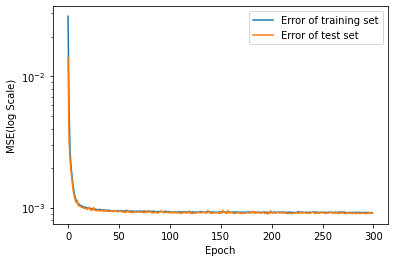

In [ ]:
#Ploting loss in log scale
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(train_error, label = "Error of training set")
ax.plot(test_error, label = "Error of validation set")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE(log Scale)")
ax.legend()
plt.show()

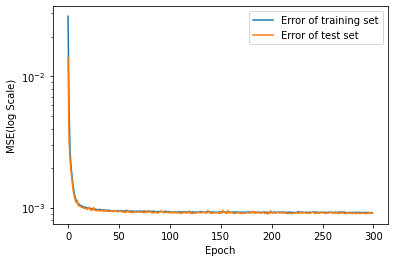

In [ ]:
#Ploting loss in log scale
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(train_error, label = "Error of training set")
ax.plot(test_error, label = "Error of validation set")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE(log Scale)")
ax.legend()
plt.show()